In [2]:
import pandas as pd
from hdbscan import HDBSCAN
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv('data.csv', encoding='latin1')

In [4]:
df = df.drop(['ID'], axis=1)

In [5]:
df.head()

,screenResolution,userGender,userAgeBracket,language,bounceRate,avgSessionDuration,avgTimeOnPage,sessions,year,dayOfWeek,deviceCategory,pagePath,minute,browserSize,city,region,country
0,720x1280,male,45-54,es-us,86.666667,69.533333,1043.000000,45.0,2017,NaN,mobile,NaN,NaN,NaN,NaN,NaN,Peru
1,720x1280,male,35-44,es-us,76.623377,125.285714,83.086207,77.0,2017,NaN,mobile,NaN,NaN,NaN,NaN,NaN,Peru
2,720x1280,male,25-34,es-us,75.942029,38.568116,70.786096,345.0,2017,NaN,mobile,NaN,NaN,NaN,NaN,NaN,Peru
3,720x1280,male,18-24,es-us,82.857143,48.635714,166.073171,140.0,2017,NaN,mobile,NaN,NaN,NaN,NaN,NaN,Peru
4,720x1280,female,25-34,es-us,47.058824,247.372549,74.650888,51.0,2017,NaN,mobile,NaN,NaN,NaN,NaN,NaN,Peru


### Convert all categoricals to dummies

In [6]:
cats = df.select_dtypes(include=['object']).columns.values

In [7]:
df = pd.get_dummies(df, prefix=cats, columns=cats)

### Fill nulls with zeroes

In [8]:
df = df.fillna(0)

In [9]:
df.head()

,bounceRate,avgSessionDuration,avgTimeOnPage,sessions,year,dayOfWeek,minute,screenResolution_1024x600,screenResolution_1024x768,screenResolution_1024x820,...,browserSize_320x450,browserSize_320x460,browserSize_320x490,city_(not set),city_La Victoria,city_Santiago de Surco,region_(not set),region_Cusco,region_Lima Region,country_Peru
0,86.666667,69.533333,1043.000000,45.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,76.623377,125.285714,83.086207,77.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,75.942029,38.568116,70.786096,345.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,82.857143,48.635714,166.073171,140.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,47.058824,247.372549,74.650888,51.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Clustering with HDBSCAN

In [10]:
hdb = HDBSCAN(min_cluster_size=50)
cluster_labels = hdb.fit_predict(df)
cluster_labels = [_ + 2 for _ in cluster_labels]

In [28]:
clusters = pd.Series(cluster_labels)
probabilities = pd.Series(hdb.probabilities_)

df['cluster'] = clusters
df['cluster_prob'] = probabilities

cluster_names = list(range(1, len(df['cluster'].value_counts()) + 1))

print('Found {} clusters.'.format(len(cluster_names)))

df.head()

Found 3 clusters.


,bounceRate,avgSessionDuration,avgTimeOnPage,sessions,year,dayOfWeek,minute,screenResolution_1024x600,screenResolution_1024x768,screenResolution_1024x820,...,browserSize_320x490,city_(not set),city_La Victoria,city_Santiago de Surco,region_(not set),region_Cusco,region_Lima Region,country_Peru,cluster,cluster_prob
0,86.666667,69.533333,1043.000000,45.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.0
1,76.623377,125.285714,83.086207,77.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,2,1.0
2,75.942029,38.568116,70.786096,345.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.0
3,82.857143,48.635714,166.073171,140.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.0
4,47.058824,247.372549,74.650888,51.0,2017,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.0


In [38]:
df['cluster'].value_counts()

1    299
3    112
2     94
Name: cluster, dtype: int64

## CART on clusters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

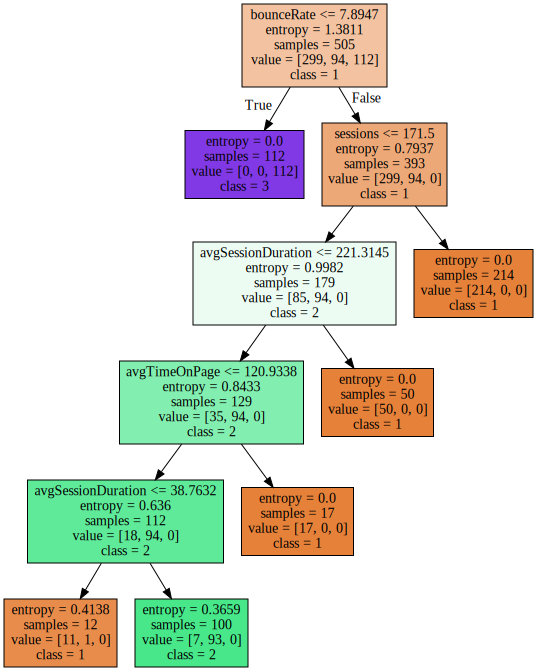

In [32]:
X = df.drop(['cluster', 'cluster_prob'], axis=1)  # drop targets
y = df['cluster']

dtc = DecisionTreeClassifier(random_state=0, max_depth=5, criterion='entropy')
dtc.fit(X, y)

graph = Source(tree.export_graphviz(dtc, out_file=None, feature_names=X.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

## CART on clusters removing metrics

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

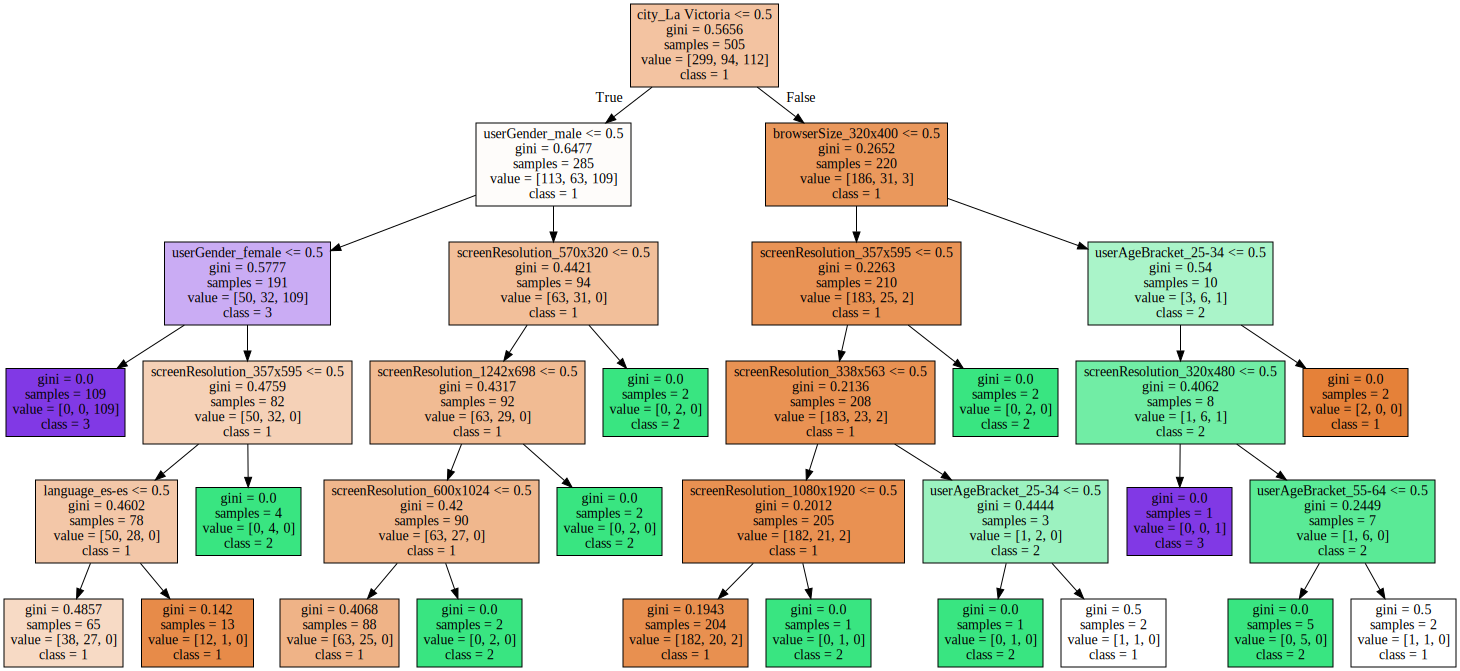

In [40]:
# X = X.drop(['bounceRate', 'sessions', 'avgSessionDuration', 'avgTimeOnPage'], axis=1)  # drop metrics

dtc = DecisionTreeClassifier(random_state=0, max_depth=5, criterion='gini')
dtc.fit(X, y)

graph = Source(tree.export_graphviz(dtc, out_file=None, feature_names=X.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))